In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import collections
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt') # for sent_tokenize
nltk.download('stopwords') 
nltk.download('wordnet') # for WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('wordnet2022')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet
from sklearn.model_selection import train_test_split
import re
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
sns.set(style="whitegrid", context='talk', 
        palette=['#D44D5C', '#43AA8B'])

import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!


In [3]:
sns.color_palette("tab10")
from sklearn.metrics import confusion_matrix

In [4]:
df = pd.read_csv('../input/product-categorization/Stationery.csv',encoding='cp1252')
df1 = pd.read_csv('../input/product-categorization/Electronics_Comp.csv',encoding='cp1252')
# df2 = pd.read_csv('../input/product-categorization/Apparel.csv')
# df3 = pd.read_csv('../input/product-categorization/Beauty.csv')
df4 = pd.read_csv('../input/product-categorization/Edibles.csv')
df5 = pd.read_csv('../input/product-categorization/Wearables-DFE.csv',encoding='cp1252')
df6 = pd.read_csv('../input/product-categorization/stationery_additional.csv')

df1 = df1[["Products","Category"]]
df = df[["Products","Category"]]
# df2 = df2[["Products","Category"]]
# df3 = df3[["Products","Category"]]
df4 = df4[["Products","Category"]]
df5 = df5[["Products","Category"]]
df6 = df6[["Products","Category"]]

# df2 = df2.sample(n=30000,random_state=1)
# df3 = df3.sample(n=30000,random_state=1)



In [5]:
df = df.append(df1,ignore_index=True)
# df = df.append(df2,ignore_index=True)
# df = df.append(df3,ignore_index=True)
df = df.append(df4,ignore_index=True)
df = df.append(df5,ignore_index=True)
df = df.append(df6,ignore_index=True)
# df = dummy_df.copy()
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.drop(df.loc[df['Category']=='[Vertical & Horizontal Stand][Multiple Viewing Angles] [Reinforced Drop Protection] Flexible TPU Bumper Back Cover-Clear'].index, inplace=True)

In [6]:
df.loc[len(df.index)] = ['BINGO YUMMITOS', 'Edibles'] 
df.loc[len(df.index)] = ['BINGO CHILLI SPRINKLED', 'Edibles'] 
df.loc[len(df.index)] = ['CHIPS', 'Edibles'] 
df.loc[len(df.index)] = ['WHEAT RICE JOWAR', 'Edibles'] 
df.loc[len(df.index)] = ['ICE CREAM', 'Edibles'] 

In [7]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head()

,Products,Category,category_id
0,2017 hot new products hospital stationery cute...,Stationery,0
1,JF88878 150PCS 150 pieces wood case box colori...,Stationery,0
2,Stationery set of writing memo pad and pen wit...,Stationery,0
3,Factory Direct Selling Planet Cute and Funny M...,Stationery,0
4,Popular Multi-functional Office and School Sta...,Stationery,0


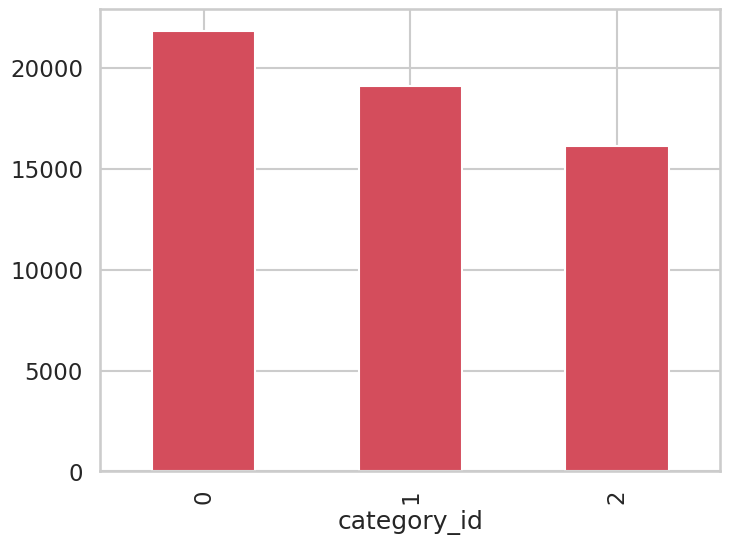

In [8]:
fig = plt.figure(figsize=(8,6))
df.groupby('category_id').Products.count().plot.bar(ylim=0)
plt.show()

In [10]:
df.Category.unique()

array(['Stationery', 'Electronics', 'Edibles'], dtype=object)

In [11]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df['Products'], df['category_id'], test_size=0.3, random_state=42)

In [34]:
xtrain, xvalid, ytrain, yvalid = train_test_split(X_train, y_train, 
                                                  stratify=y_train, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [35]:
print (xtrain.shape)
print (xvalid.shape)
print (X_test.shape)

(35932,)
(3993,)
(17111,)


In [36]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid) + list(X_test))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
xtest_tfv = tfv.transform(X_test)

logloss: 0.116 
              precision    recall  f1-score   support

  Stationery     0.9774    0.9921    0.9847      1523
 Electronics     0.9901    0.9760    0.9830      1333
     Edibles     0.9956    0.9921    0.9938      1137

    accuracy                         0.9867      3993
   macro avg     0.9877    0.9867    0.9872      3993
weighted avg     0.9868    0.9867    0.9867      3993



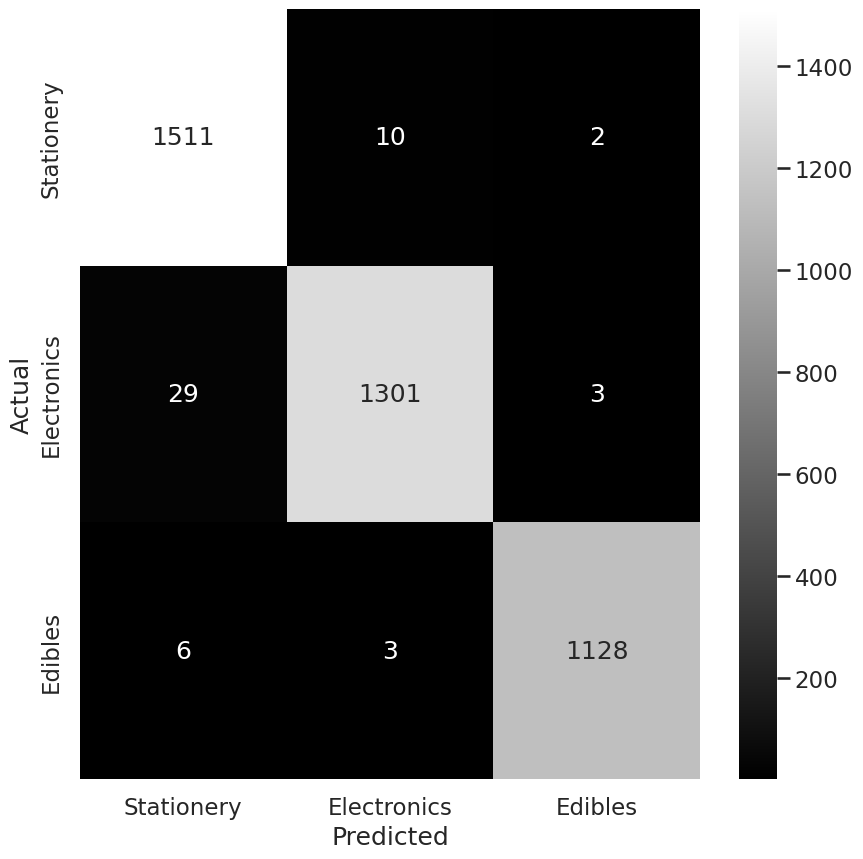

logloss: 0.112 
              precision    recall  f1-score   support

  Stationery     0.9852    0.9933    0.9893      6579
 Electronics     0.9939    0.9849    0.9894      5756
     Edibles     0.9941    0.9937    0.9939      4776

    accuracy                         0.9906     17111
   macro avg     0.9911    0.9906    0.9908     17111
weighted avg     0.9906    0.9906    0.9906     17111



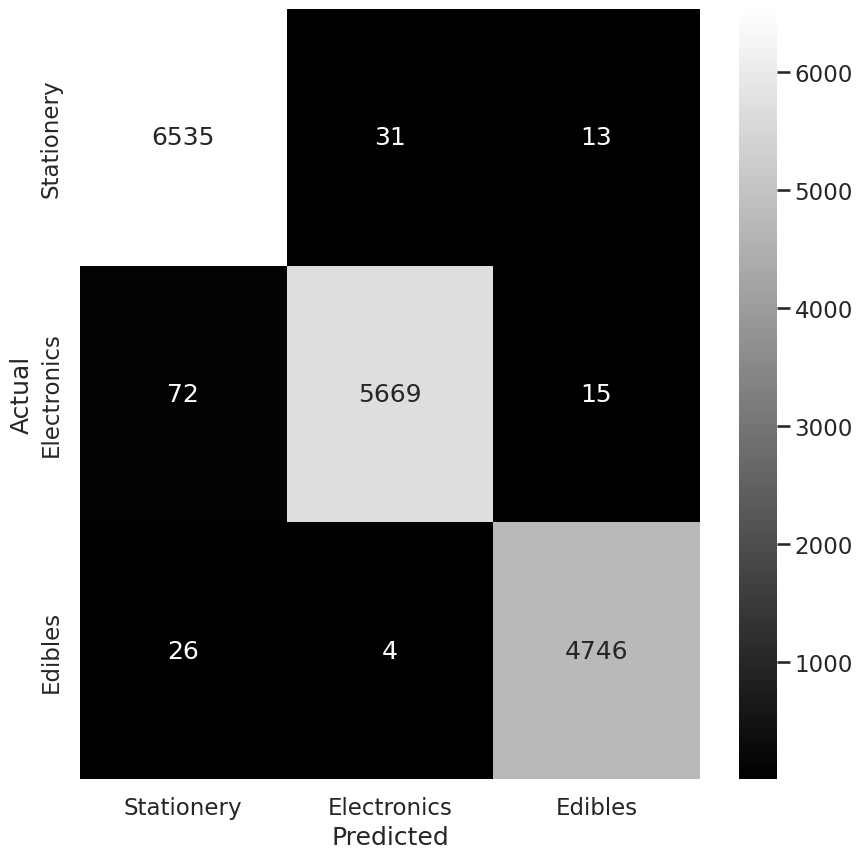

In [37]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
y_valid = clf.predict(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print(metrics.classification_report(yvalid, y_valid, digits=4,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(yvalid, y_valid)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

test_predictions = clf.predict_proba(xtest_tfv)
y_pred = clf.predict(xtest_tfv)

print ("logloss: %0.3f " % multiclass_logloss(y_test, test_predictions))
print(metrics.classification_report(y_test, y_pred, digits=4,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [ ]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)
y_pred = clf.predict(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print(metrics.classification_report(yvalid, y_pred, digits=2,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(yvalid, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

logloss: 0.062 
              precision    recall  f1-score   support

  Stationery     0.9755    0.9928    0.9841      1523
 Electronics     0.9909    0.9775    0.9841      1333
     Edibles     0.9973    0.9894    0.9934      1137

    accuracy                         0.9867      3993
   macro avg     0.9879    0.9866    0.9872      3993
weighted avg     0.9868    0.9867    0.9867      3993



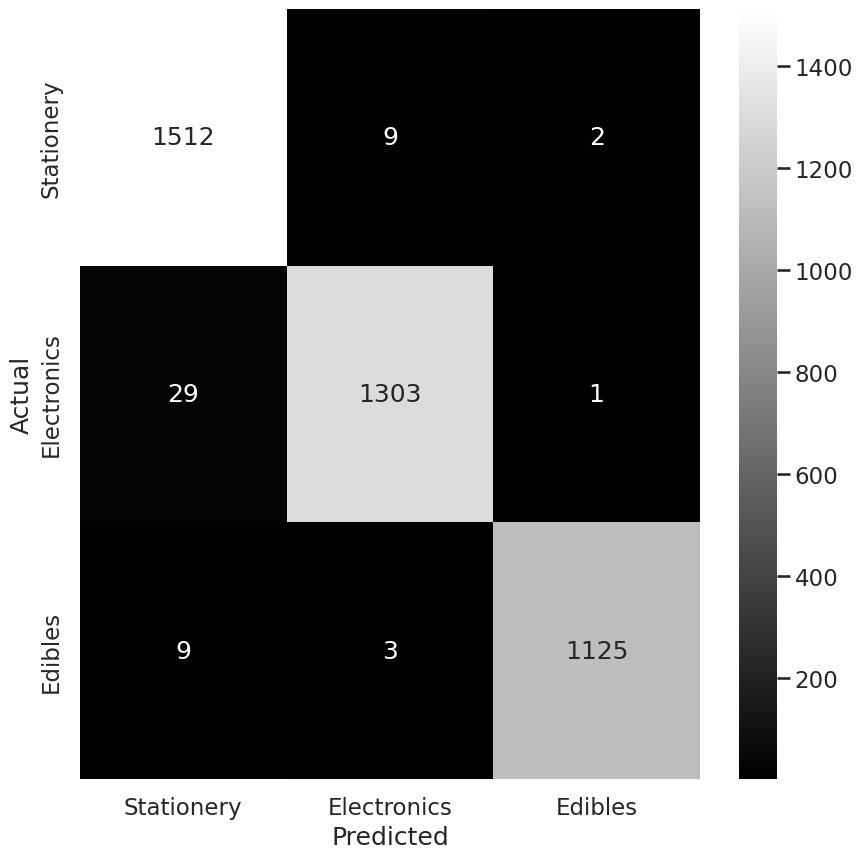

logloss: 0.059 
              precision    recall  f1-score   support

  Stationery     0.9793    0.9942    0.9867      6579
 Electronics     0.9923    0.9864    0.9894      5756
     Edibles     0.9989    0.9851    0.9920      4776

    accuracy                         0.9891     17111
   macro avg     0.9902    0.9886    0.9894     17111
weighted avg     0.9892    0.9891    0.9891     17111



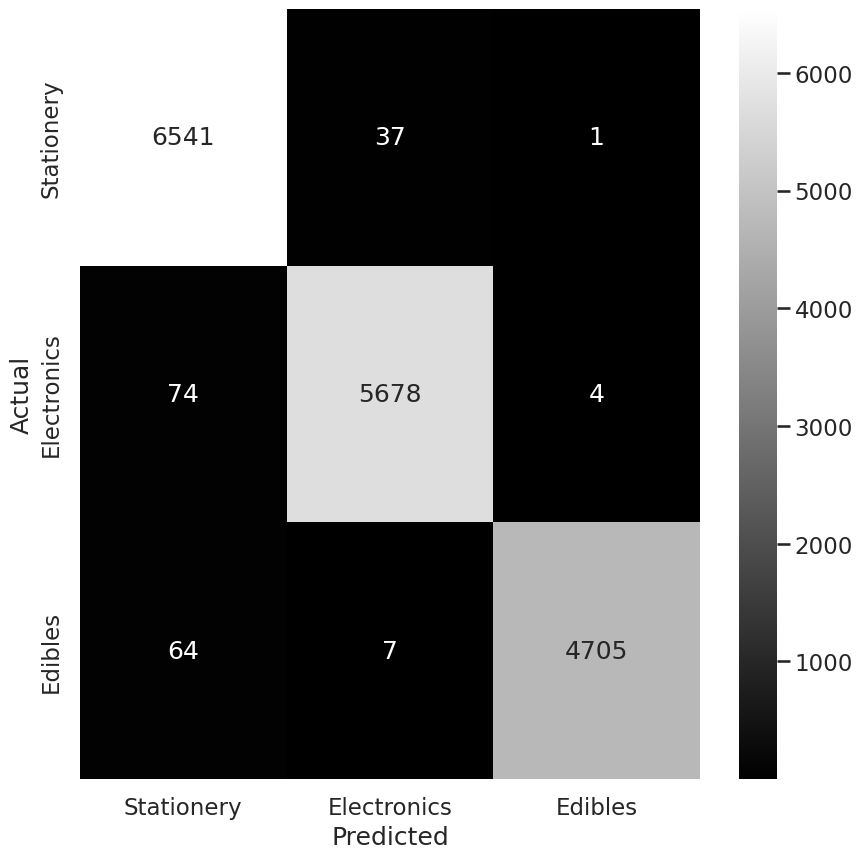

In [38]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
y_pred = clf.predict(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print(metrics.classification_report(yvalid, y_pred, digits=4,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(yvalid, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

test_predictions = clf.predict_proba(xtest_tfv)
y_pred = clf.predict(xtest_tfv)

print ("logloss: %0.3f " % multiclass_logloss(y_test, test_predictions))
print(metrics.classification_report(y_test, y_pred, digits=4,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)
y_pred = clf.predict(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print(metrics.classification_report(yvalid, y_pred, digits=2,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(yvalid, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

              precision    recall  f1-score   support

  Stationery     0.9850    0.9915    0.9882      1523
 Electronics     0.9924    0.9842    0.9883      1333
     Edibles     0.9956    0.9965    0.9960      1137

    accuracy                         0.9905      3993
   macro avg     0.9910    0.9907    0.9909      3993
weighted avg     0.9905    0.9905    0.9905      3993



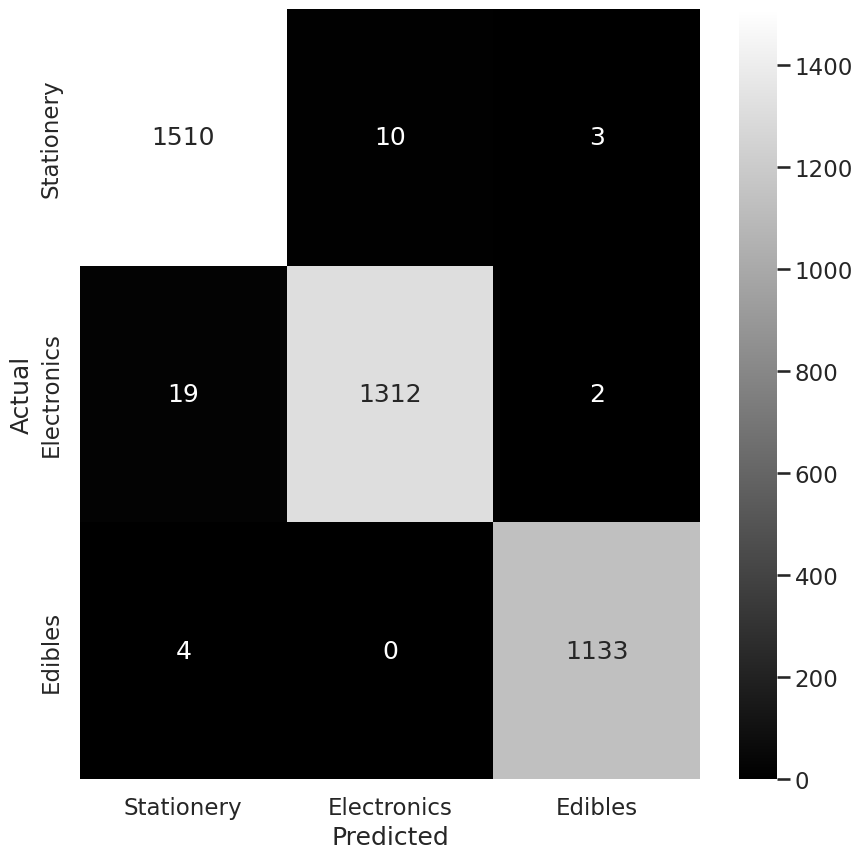

              precision    recall  f1-score   support

  Stationery     0.9907    0.9918    0.9913      6579
 Electronics     0.9930    0.9897    0.9914      5756
     Edibles     0.9952    0.9977    0.9964      4776

    accuracy                         0.9928     17111
   macro avg     0.9930    0.9931    0.9930     17111
weighted avg     0.9928    0.9928    0.9928     17111



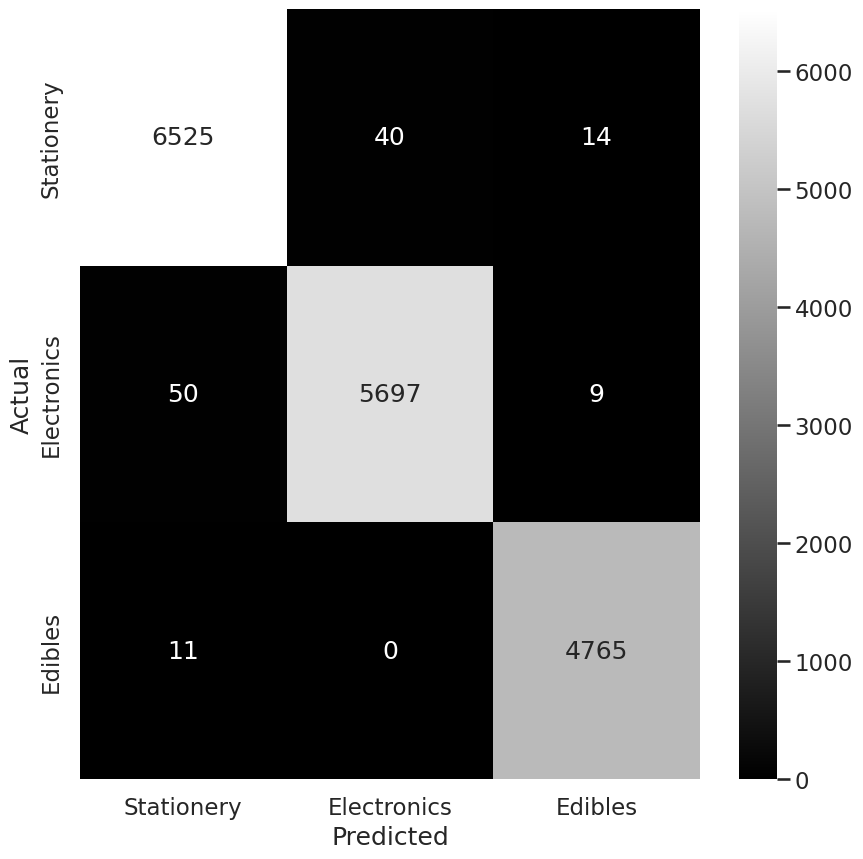

In [39]:
# Fitting a simple SVM
from sklearn.svm import LinearSVC
clf = LinearSVC() # since we need probabilities
clf.fit(xtrain_tfv, ytrain)
#predictions = clf.predict_proba(xvalid_tfv)
y_pred = clf.predict(xvalid_tfv)

# ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print(metrics.classification_report(yvalid, y_pred, digits=4,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(yvalid, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#test_predictions = clf.predict_proba(xtest_tfv)
y_pred = clf.predict(xtest_tfv)

#print ("logloss: %0.3f " % multiclass_logloss(y_test, test_predictions))
print(metrics.classification_report(y_test, y_pred, digits=4,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)
y_pred = clf.predict(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print(metrics.classification_report(yvalid, y_pred, digits=2,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(yvalid, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print(metrics.classification_report(yvalid, predictions, digits=2,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(yvalid, predictions)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_ctv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_ctv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print(metrics.classification_report(yvalid, predictions, digits=2,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(yvalid, predictions)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [44]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=200)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)
xtest_svd = svd.transform(xtest_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)
xtest_svd_scl = scl.transform(xtest_svd)

In [ ]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print(metrics.classification_report(yvalid, predictions, digits=2,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(yvalid, predictions)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#test_predictions = clf.predict_proba(xtest_tfv)
y_pred = clf.predict(xtest_svd_scl)

#print ("logloss: %0.3f " % multiclass_logloss(y_test, test_predictions))
print(metrics.classification_report(y_test, y_pred, digits=4,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


              precision    recall  f1-score   support

  Stationery     0.9599    0.9750    0.9674      1523
 Electronics     0.9772    0.9655    0.9713      1333
     Edibles     0.9885    0.9815    0.9850      1137

    accuracy                         0.9737      3993
   macro avg     0.9752    0.9740    0.9746      3993
weighted avg     0.9738    0.9737    0.9737      3993



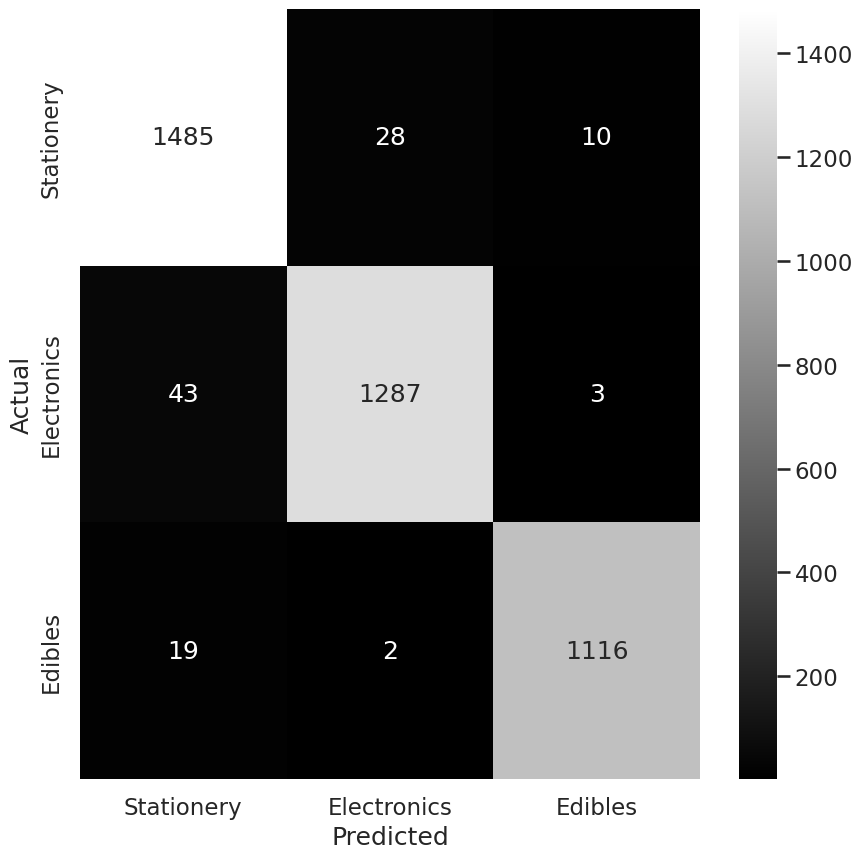

              precision    recall  f1-score   support

  Stationery     0.9670    0.9763    0.9716      6579
 Electronics     0.9809    0.9713    0.9761      5756
     Edibles     0.9853    0.9839    0.9846      4776

    accuracy                         0.9767     17111
   macro avg     0.9777    0.9772    0.9774     17111
weighted avg     0.9768    0.9767    0.9768     17111



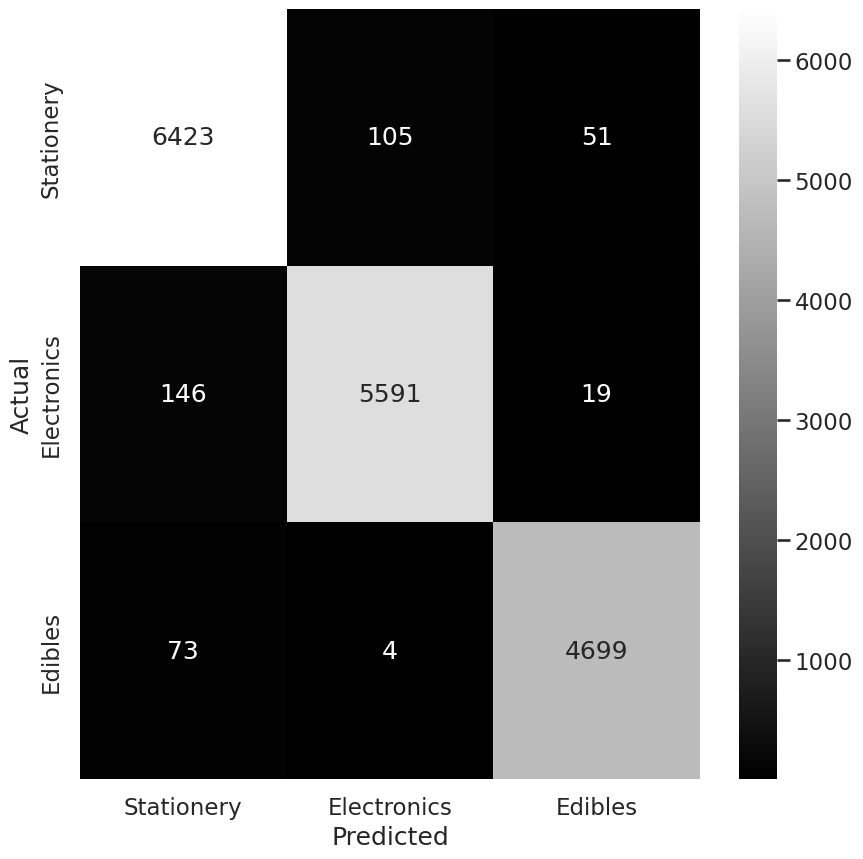

In [46]:
# Fitting a simple SVM
from sklearn.svm import LinearSVC
clf = LinearSVC() # since we need probabilities
clf.fit(xtrain_svd_scl, ytrain)
#predictions = clf.predict_proba(xvalid_tfv)
y_pred = clf.predict(xvalid_svd_scl)

# ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print(metrics.classification_report(yvalid, y_pred, digits=4,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(yvalid, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#test_predictions = clf.predict_proba(xtest_tfv)
y_pred = clf.predict(xtest_svd_scl)

#print ("logloss: %0.3f " % multiclass_logloss(y_test, test_predictions))
print(metrics.classification_report(y_test, y_pred, digits=4,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import time

In [57]:
classifiers = [['Neural Network :', MLPClassifier(max_iter = 1000)],
               ['LogisticRegression :', LogisticRegression(max_iter = 1000)],
               ['ExtraTreesClassifier :', ExtraTreesClassifier()],
               ['DecisionTree :',DecisionTreeClassifier()],
               ['RandomForest :',RandomForestClassifier()], 
               ['Gaussian Naive Bayes :', GaussianNB()],
#                ['Multinomial Naive Bayes :', MultinomialNB()],
               ['KNeighbours :', KNeighborsClassifier()],
               ['SVM :', SVC()],
               ['Linear SVC :', LinearSVC(max_iter=2000)],
               ['AdaBoostClassifier :', AdaBoostClassifier()],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
               ['XGB :', XGBClassifier()],
               ['CatBoost :', CatBoostClassifier(logging_level='Silent')]]

predictions_df = pd.DataFrame()
predictions_df['action'] = y_test

my_classification_report = {}
my_confusion_matrix = {}

for name,classifier in classifiers:
    t0 = time.time()
    classifier = classifier
    classifier.fit(xtrain_svd_scl, ytrain)
    print("Training time for {}:".format(name), time.time()-t0)
    predictions = classifier.predict(xtest_svd_scl)
    predictions_df[name.strip(" :")] = predictions
    print(name, accuracy_score(y_test, predictions))
    my_classification_report[name] = metrics.classification_report(y_test, predictions, digits=4,target_names=df['Category'].unique())
    my_confusion_matrix[name] = confusion_matrix(y_test, predictions)

    
for key in my_classification_report.keys():
    print(key, my_classification_report[key])
for key in my_confusion_matrix.keys():
    print(key, my_confusion_matrix[key])

Training time for Neural Network :: 41.98631954193115
Neural Network : 0.9821167669919935
Training time for LogisticRegression :: 5.416940927505493
LogisticRegression : 0.9767401087020046
Training time for ExtraTreesClassifier :: 18.5159695148468
ExtraTreesClassifier : 0.9762725731985272
Training time for DecisionTree :: 22.79815101623535
DecisionTree : 0.9312722809888376
Training time for RandomForest :: 71.46557593345642
RandomForest : 0.9725322891707089
Training time for Gaussian Naive Bayes :: 0.1095576286315918
Gaussian Naive Bayes : 0.8027000175325814
Training time for KNeighbours :: 0.008128166198730469
KNeighbours : 0.9595581789492139
Training time for SVM :: 60.16685748100281
SVM : 0.9763310151364619


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training time for Linear SVC :: 51.09962248802185
Linear SVC : 0.9766816667640699
Training time for AdaBoostClassifier :: 67.6095449924469
AdaBoostClassifier : 0.9043889895388931
Training time for GradientBoostingClassifier: : 992.5385684967041
GradientBoostingClassifier:  0.9663958856875694
Training time for XGB :: 212.22693514823914
XGB : 0.9810063701712349
Training time for CatBoost :: 132.7342026233673
CatBoost : 0.9797206475366723
CatBoost :               precision    recall  f1-score   support

  Stationery     0.9799    0.9783    0.9791      6579
 Electronics     0.9814    0.9830    0.9822      5756
     Edibles     0.9860    0.9864    0.9862      4776

    accuracy                         0.9821     17111
   macro avg     0.9824    0.9825    0.9825     17111
weighted avg     0.9821    0.9821    0.9821     17111

CatBoost :               precision    recall  f1-score   support

  Stationery     0.9682    0.9761    0.9721      6579
 Electronics     0.9814    0.9710    0.9762     

In [65]:
misclassifications = {}
for key in my_confusion_matrix.keys():
    s = 0
    for i in range(3):
        for j in range(3):
            if i != j:
                s += my_confusion_matrix[key][i][j]
    misclassifications[key] = s

print(sorted(misclassifications.items(), key=lambda x:x[1]))

[('Neural Network :', 306), ('XGB :', 325), ('CatBoost :', 347), ('LogisticRegression :', 398), ('Linear SVC :', 399), ('SVM :', 405), ('ExtraTreesClassifier :', 406), ('RandomForest :', 470), ('GradientBoostingClassifier: ', 575), ('KNeighbours :', 692), ('DecisionTree :', 1176), ('AdaBoostClassifier :', 1636), ('Gaussian Naive Bayes :', 3376)]


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


              precision    recall  f1-score   support

  Stationery     0.9603    0.9842    0.9721      1523
 Electronics     0.9862    0.9632    0.9746      1333
     Edibles     0.9894    0.9833    0.9863      1137

    accuracy                         0.9770      3993
   macro avg     0.9786    0.9769    0.9777      3993
weighted avg     0.9772    0.9770    0.9770      3993



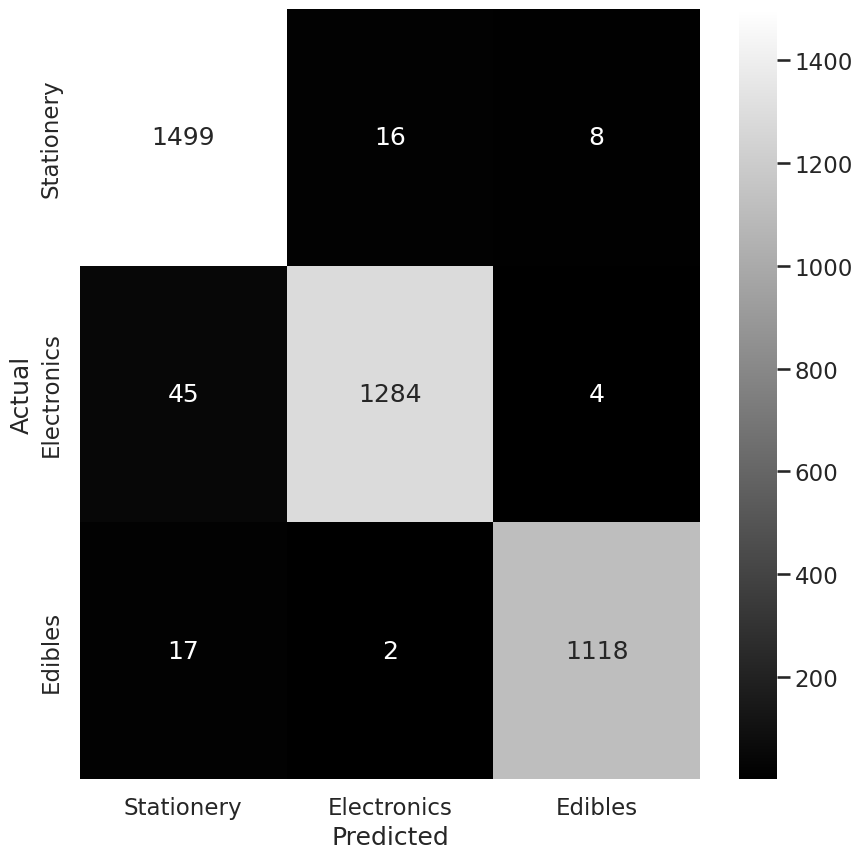

              precision    recall  f1-score   support

  Stationery     0.9645    0.9883    0.9763      6579
 Electronics     0.9909    0.9699    0.9803      5756
     Edibles     0.9907    0.9824    0.9865      4776

    accuracy                         0.9805     17111
   macro avg     0.9821    0.9802    0.9811     17111
weighted avg     0.9807    0.9805    0.9805     17111



In [77]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

# get a stacking ensemble of models
def get_stacking():
    
    level0 = list()
    level0.append(('clf1', MLPClassifier(max_iter = 1000)))
    level0.append(('clf2', LogisticRegression(max_iter = 1000)))
    level0.append(('clf3', LinearSVC()))
    level0.append(('clf4', ExtraTreesClassifier()))
    level0.append(('clf5', KNeighborsClassifier()))
    level0.append(('clf6', RandomForestClassifier()))

  # define meta learner model
    level1 = LogisticRegression()
  # define the stacking ensemble
    model = VotingClassifier(estimators=level0, voting ='hard')
    return model
                  
clf = get_stacking()
clf.fit(xtrain_svd_scl, ytrain)

y_pred = clf.predict(xvalid_svd_scl)


print(metrics.classification_report(yvalid, y_pred, digits=4,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(yvalid, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


y_pred = clf.predict(xtest_svd_scl)


print(metrics.classification_report(y_test, y_pred, digits=4,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(y_test, y_pred)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

              precision    recall  f1-score   support

  Stationery     0.9746    0.9810    0.9777      1523
 Electronics     0.9826    0.9760    0.9793      1333
     Edibles     0.9877    0.9868    0.9872      1137

    accuracy                         0.9810      3993
   macro avg     0.9816    0.9813    0.9814      3993
weighted avg     0.9810    0.9810    0.9810      3993



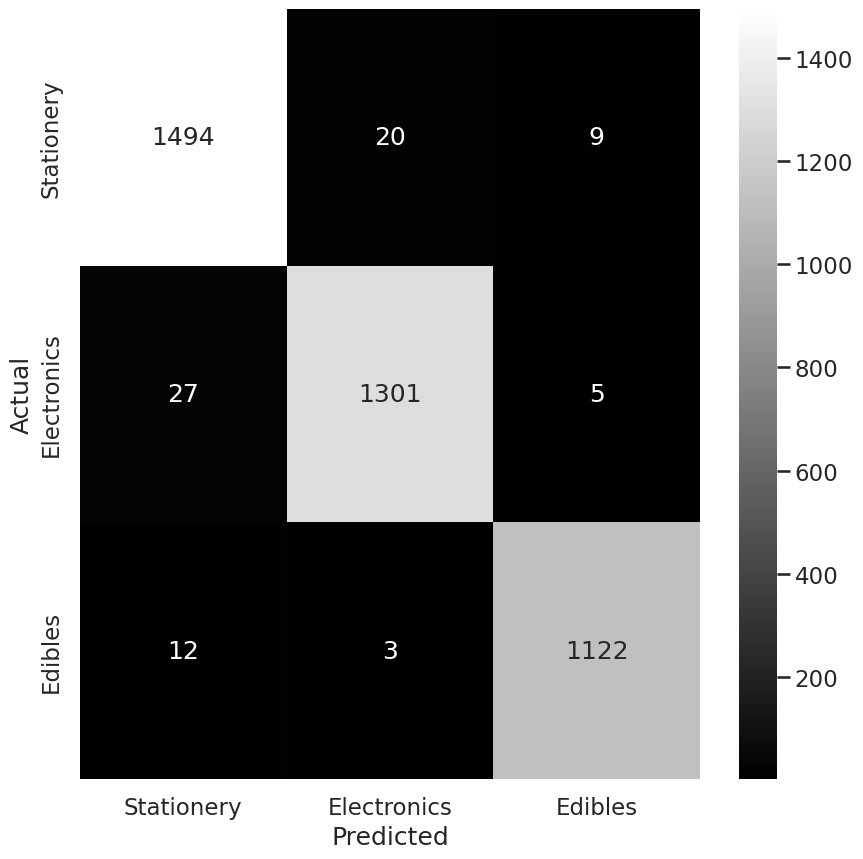

              precision    recall  f1-score   support

  Stationery     0.9788    0.9819    0.9803      6579
 Electronics     0.9843    0.9826    0.9835      5756
     Edibles     0.9895    0.9872    0.9884      4776

    accuracy                         0.9836     17111
   macro avg     0.9842    0.9839    0.9841     17111
weighted avg     0.9836    0.9836    0.9836     17111



In [84]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

# get a stacking ensemble of models
def get_stacking():
    
    level0 = list()
    level0.append(('clf1', MLPClassifier(max_iter = 1000)))
    level0.append(('clf2', LogisticRegression(max_iter = 2000)))
    level0.append(('clf3', LinearSVC(max_iter = 8000)))
    level0.append(('clf4', ExtraTreesClassifier()))
    level0.append(('clf5', KNeighborsClassifier()))

  # define meta learner model
    level1 = LogisticRegression(max_iter = 2000)
  # define the stacking ensemble
    model = StackingClassifier(estimators=level0)
    return model
                  
clf = get_stacking()
clf.fit(xtrain_svd_scl, ytrain)

y_pred = clf.predict(xvalid_svd_scl)


print(metrics.classification_report(yvalid, y_pred, digits=4,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(yvalid, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


y_pred = clf.predict(xtest_svd_scl)


print(metrics.classification_report(y_test, y_pred, digits=4,target_names=df['Category'].unique()))

conf_mat = confusion_matrix(y_test, y_pred)

In [85]:
print(conf_mat)

[[6460   84   35]
 [  85 5656   15]
 [  55    6 4715]]


In [86]:
s = 0
for i in range(3):
    for j in range(3):
        if i != j:
            s += conf_mat[i][j]
print(s)

280


In [55]:
classifiers = [#['Neural Network :', MLPClassifier(max_iter = 1000)],
               ['LogisticRegression :', LogisticRegression(max_iter = 1000)],
               ['ExtraTreesClassifier :', ExtraTreesClassifier()],
               ['DecisionTree :',DecisionTreeClassifier()],
               ['RandomForest :',RandomForestClassifier()], 
               ['Gaussian Naive Bayes :', GaussianNB()],
               ['Multinomial Naive Bayes :', MultinomialNB()],
               ['KNeighbours :', KNeighborsClassifier()],
               ['Linear SVC :', LinearSVC()],
               ['AdaBoostClassifier :', AdaBoostClassifier()],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
               ['XGB :', XGBClassifier()],
               ['CatBoost :', CatBoostClassifier(logging_level='Silent')]]

predictions_df = pd.DataFrame()
predictions_df['action'] = y_test

my_classification_report = {}
my_confusion_matrix = {}

for name,classifier in classifiers:
    t0 = time.time()
    classifier = classifier
    classifier.fit(xtrain_tfv, ytrain)
    print("Training time for {}:".format(name), time.time()-t0)
    predictions = classifier.predict(xtest_tfv)
    predictions_df[name.strip(" :")] = predictions
    print(name, accuracy_score(y_test, predictions))
    my_classification_report[name] = metrics.classification_report(y_test, predictions, digits=4,target_names=df['Category'].unique())
    my_confusion_matrix = confusion_matrix(y_test, predictions)

for key in my_classification_report.keys():
    print(name, my_classification_report[key])
for key in my_confusion_matrix.keys():
    print(name, my_confusion_matrix[key])

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training time for Neural Network :: 276.5129327774048
Neural Network : 0.9931038513237099


KeyboardInterrupt: 

In [ ]:
stop_words = stopwords.words("english")
# stop_words.extend(["personal","beauty","care","combo","cannot", "could", "done", "let", "may" "mayn",  "might", "must", "need","women's","men's","stationery", "-", "kid", "ought", "oughtn", "shall", "would", "br","hot","new","sale","offer","off","old",'wholesale'])
lemmatizer = WordNetLemmatizer()
# stop_words.extend(["black","similar","global","stationery","gift","pack","products","school","office","product","supply","color","colour","red","blue","green","smartnxt","quality","high","low","big","small","pad","x","women","men","girl","boy","inch","woman","man","baby","one","large","cotton","pieces","free"])
df.Products = df.Products.apply(lambda i: " ".join(lemmatizer.lemmatize(i.lower()) for i in i.split() if i not in stop_words))

In [ ]:
split = df.Products.apply(lambda i: i.split())
splits = []
for each in split:
  splits.extend(each)

len(splits)

len(set(splits))

freq_splits = FreqDist(splits)
print(freq_splits.most_common(10))

short = set(s for s in splits if len(s)<4)
short = [(s, freq_splits[s]) for s in short]
short.sort(key=lambda x:x[1], reverse=True)
short[:15]

long = set(s for s in splits if len(s)>15)
long = [(s, freq_splits[s]) for s in long]
long.sort(key=lambda x:x[1], reverse=True)
long[:15]

def summarise(pattern, strings, freq):
    print("Called Summarise")
    """Summarise strings matching a pattern."""
    # Find matches
    compiled_pattern = re.compile(pattern)
    matches = [s for s in strings if compiled_pattern.search(s)]
    
    # Print volume and proportion of matches
    print("{} strings, that is {:.2%} of total".format(len(matches), len(matches)/ len(strings)))
    
    # Create list of tuples containing matches and their frequency
    output = [(s, freq[s]) for s in set(matches)]
    output.sort(key=lambda x:x[1], reverse=True)
    
    return output

summarise(r"\d", splits, freq_splits)[:10]

summarise(r"\w+-+\w+", splits, freq_splits)[:15]

summarise(r"\w+[_!&/)(<\|}{\[\]]\w+", splits, freq_splits)[:15]

def find_outlaw(word):
    """Find words that contain a same character 3+ times in a row."""
    is_outlaw = False
    for i, letter in enumerate(word):
        if i > 1:
            if word[i] == word[i-1] == word[i-2] and word[i].isalpha():
                is_outlaw = True
                break
    return is_outlaw
outlaws = [s for s in splits if find_outlaw(s)]
print("{} strings, that is {:.2%} of total (outlaw)".format(len(outlaws), len(outlaws)/ len(splits)))
outlaw_freq = [(s, freq_splits[s]) for s in set(outlaws)]
outlaw_freq.sort(key=lambda x:x[1], reverse=True)
outlaw_freq

complete_string = " ".join(splits)

complete_string[:100]

tokeniser = RegexpTokenizer("(?:\d+[a-zA-Z]+|[a-zA-Z]+\d+|[\w+[_!&/)(<\|}{\[\]]\w+]+|[a-zA-Z]+)")
tokens = tokeniser.tokenize(complete_string)
print(len(tokens))
print(tokens[:20], "\n")

freq_tokens = FreqDist(tokens)
print(freq_tokens.most_common(10))
summarise(r"\d+", tokens, freq_tokens)[:15]

lemmatiser = WordNetLemmatizer()
tokens_norm = [lemmatiser.lemmatize(t.lower(), "v") for t in tokens]
print(f"Number of unique tokens: {len(set(tokens_norm))}")

# Create list of token lengths for each token
token_length = [len(t) for t in tokens]
# Average number of characters per token
print(f"Average number of characters per token: {round(np.mean(token_length),4)}")
# Plot distribution
plt.figure(figsize=(12, 12))
sns.countplot(y=token_length)
plt.title("Counts of token length", size=20);



freq_stopwords = [(sw, tokens_norm.count(sw)) for sw in stop_words]
freq_stopwords.sort(key=lambda x: x[1], reverse=True)
freq_stopwords[:10]

tokens_clean = [t for t in tokens_norm if t not in stop_words]
print(f"Number of tokens: {len(tokens_clean)}")

print(f"Number of unique tokens: {len(set(tokens_clean))}")

In [ ]:
def get_data(gen):
    try:
        for elem in gen:
            yield elem
    except (RuntimeError, StopIteration):
        return
def preprocess_text(text):
    """Preprocess text into normalised tokens."""
    # Tokenise words into alphabetic tokens
    tokeniser = RegexpTokenizer("(?:\d+[a-zA-Z]+|[a-zA-Z]+\d+|[\w+[_!&/)(<\|}{\[\]]\w+]+|[a-zA-Z]+)")
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stop_words]
    return keywords
def get_frequent_ngram(corpus, ngram, n=20):
    """Find most common n n-grams tokens."""
    # Preprocess each document
    documents = [preprocess_text(document) for document in corpus]
    
    # Find ngrams per document
    n_grams = [list(get_data(ngrams(document, ngram))) for document in documents]
    
    # Find frequency of ngrams
    n_grams_flattened = [item for sublist in n_grams for item in sublist]
    freq_dist = FreqDist(n_grams_flattened)
    top_freq = freq_dist.most_common(n)
    return pd.DataFrame(top_freq, columns=["ngram", "count"])
# Get frequent ngrams for all 4
for i in range(1,4):
    mapping = {1:"uni", 2:"bi", 3:"tri"}
    plt.figure(figsize=(12,10))
    sns.barplot(x="count", y="ngram", data=get_frequent_ngram(df['Products'], i))
    plt.title(f"Most common {mapping[i]}grams")

In [ ]:
df.dropna(inplace=True)

In [ ]:
print(len(df))

In [ ]:
df.head()

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Products'], df['category_id'], test_size=0.3, random_state=42)

In [ ]:
UnComment for sampling
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.under_sampling import TomekLinks
# from imblearn.over_sampling import SMOTE


# # Identify the minority and majority classes in the training set
# minority_class = y_train.value_counts().idxmin()
# majority_class = y_train.value_counts().idxmax()

# # Apply undersampling to the majority class using RandomUnderSampler or TomekLinks
# rus = RandomUnderSampler(random_state=42)
# X_train_resampled, y_train_resampled = rus.fit_resample(X_train.to_frame(), y_train)
# # or
# # tl = TomekLinks(random_state=42)
# # X_train_resampled, y_train_resampled = tl.fit_resample(X_train.to_frame(), y_train)

# # Apply oversampling to the minority class using SMOTE
# # smote = SMOTE(random_state=42)
# # X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

# # Combine the original minority class data with the synthetic data generated by SMOTE
# train_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)

# # Shuffle the resulting balanced dataset
# train_resampled = train_resampled.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
#Run this if not sampling (not running above cell)
train_resampled = pd.concat([X_train, y_train], axis=1)
train_resampled = train_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
len(train_resampled)

In [ ]:
train_resampled.head()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, max_df=0.9, norm='l2', encoding='latin-1', ngram_range=(2, 3), stop_words='english')
features = tfidf.fit_transform(train_resampled.Products).toarray()
labels = train_resampled.category_id
features.shape

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import numpy as np

vectorizer = TfidfVectorizer()
# Define the data generator function
def data_generator(data_df, batch_size):
    # Initialize the TF-IDF vectorizer
    

    # Fit the vectorizer to the data
    vectorizer.fit(data_df['Products'])

    # Loop through the data in batches
    num_batches = len(data_df) // batch_size
    print(num_batches)
    for i in range(num_batches):
        # Get the current batch of data
        batch_df = data_df.iloc[i*batch_size:(i+1)*batch_size]
#         print(batch_df.shape)
        # Convert the text to TF-IDF vectors
        X = vectorizer.transform(batch_df['Products'])

        # Get the labels
        y = batch_df['category_id']

        # Yield the data
        yield X, y




In [ ]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC


# get a stacking ensemble of models
def get_stacking():
	# define the base models
  level0 = list()
  level0.append(('rf', RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42,class_weight='balanced')))
  level0.append(('svm', LinearSVC()))
  level0.append(('nb', MultinomialNB()))

  # define meta learner model
  level1 = LogisticRegression()
  # define the stacking ensemble
  model = StackingClassifier(estimators=level0,final_estimator=level1, cv=5)
  return model


In [ ]:
# Define the SVM model
model_nb = MultinomialNB()

# Define the data and batch size

batch_size = 10000

# Train the model on the data generator
generator = data_generator(train_resampled, batch_size)
print (generator)
for X, y in generator:
    model_stack.fit(X, y)

# Save the trained model
# np.savez('model.npz', coef=model.coef_, intercept=model.intercept_)

In [ ]:
model_nb = MultinomialNB()
model_pytorch = convert(model_stack, 'torch')
%%capture 
model_pytorch.to('cuda')

In [ ]:
model_stack.fit(features, labels)

In [ ]:
X_test_tfidf = tfidf.transform(X_test)
y_pred_stack = model_stack.predict(X_test_tfidf)
sns.color_palette("tab10")
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_stack)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred_stack, digits=5,target_names=df['Category'].unique()))

pred_prob = model_stack.predict_proba(X_test_tfidf)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Stationery vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Edibles vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Beauty vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [ ]:
# Define the SVM model
model_NB = MultinomialNB()

# Define the data and batch size

batch_size = len(train_resampled)

# Train the model on the data generator
generator = data_generator(train_resampled, batch_size)
print (generator)
for X, y in generator:
    model_NB.fit(X, y)

In [ ]:
X_test_tfidf = vectorizer.transform(X_test)
y_pred_stack = model_NB.predict(X_test_tfidf)
sns.color_palette("tab10")
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred_stack)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred_stack, digits=2,target_names=df['Category'].unique()))

pred_prob = model_stack.predict_proba(X_test_tfidf)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Stationery vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Edibles vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Beauty vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot

def compare_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['nbayes'] = MultinomialNB()
    models['stacking'] = get_stacking()
    return models


In [ ]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

batch_size = len(df)
generator = data_generator(df, batch_size)

    
# get the models to evaluate
models = compare_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    for X, y in generator:
        scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
from sklearn.svm import LinearSVC
from scipy.sparse import load_npz

def batch_generator(data_file, batch_size,labels):
    data = load_npz(data_file)
    for i in range(0, data.shape[0], batch_size):
        yield data[i:i+batch_size], labels[i:i+batch_size]

data_file = "tfidf_features.npz"
batch_size = 200
model = MultinomialNB()

for X_batch, y_batch in batch_generator(data_file, batch_size,y_train):
    model.fit(X_batch, y_batch)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Define your corpus
corpus = ["This is document 1", "This is document 2", ..., "This is document N"]
labels = [0, 1, ..., N-1]

# Define your batch size
batch_size = 1000

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Create a MultinomialNB object
clf = MultinomialNB()

# Loop over each batch and process it
for i in range(0, len(corpus), batch_size):
    # Get the current batch
    batch = corpus[i:i + batch_size]
    batch_labels = labels[i:i + batch_size]

    # Fit the vectorizer to the current batch
    vectorizer.partial_fit(batch)

    # Transform the current batch
    batch_vectorized = vectorizer.transform(batch)

    # Train the classifier on the current batch
    clf.partial_fit(batch_vectorized, batch_labels, classes=np.unique(labels))

# Evaluate the model on a holdout set
holdout_corpus = ["This is a test document", "This is another test document", ..., "This is the final test document"]
holdout_labels = [0, 1, ..., N-1]
holdout_vectorized = vectorizer.transform(holdout_corpus)
accuracy = clf.score(holdout_vectorized, holdout_labels)
print("Accuracy: {:.2f}".format(accuracy))


In [ ]:
import pickle
with open('features.pk', 'wb') as fin:
    pickle.dump(features, fin)

In [ ]:
X = features[:80000]
Y = labels[:80000]
X_test = features[80001:]
Y_test = labels[80001:]

In [ ]:
len(X_test)

In [ ]:
model = MultinomialNB()
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)
model.fit(X, labels)
y_pred = model.predict(X_test)
sns.color_palette("tab10")
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

In [ ]:
pred_prob = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Stationery vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Edibles vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Beauty vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
pred_prob = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Stationery vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Edibles vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Beauty vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

In [ ]:
model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)

In [ ]:
print("Hello World")

In [ ]:
Y.unique()

In [ ]:
def batches(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

In [ ]:
from sklearn.linear_model import SGDClassifier
import random
clf2 = SGDClassifier(loss='log') # shuffle=True is useless here
n_iter = 5
for n in range(n_iter):
    for batch in batches(range(len(X)), 10000):
        clf2.partial_fit(X[batch[0]:batch[-1]+1], Y[batch[0]:batch[-1]+1], classes=np.unique(Y))

In [ ]:
y_pred = clf2.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(Y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

In [ ]:
model = RandomForestClassifier(n_estimators=200, max_depth=4, random_state=0,class_weight='balanced')
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
pred_prob = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Stationery vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Edibles vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Beauty vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_stack, target_names=df['Category'].unique()))

In [ ]:
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [ ]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier



# get a stacking ensemble of models
def get_stacking():
	# define the base models
  level0 = list()
  level0.append(('rf', RandomForestClassifier(n_estimators=200, max_depth=4, random_state=0,class_weight='balanced')))
  level0.append(('svm', LinearSVC()))
  level0.append(('nb', MultinomialNB()))

  # define meta learner model
  level1 = LogisticRegression()
  # define the stacking ensemble
  model = StackingClassifier(estimators=level0,final_estimator=level1, cv=5)
  return model

# model = get_stacking()
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3,stratify=labels, random_state=0)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# from sklearn.metrics import confusion_matrix
# conf_mat = confusion_matrix(y_test, y_pred)
# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
#             xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()

In [ ]:
# Define the SVM model
model_stack = get_stacking()

# Define the data and batch size

batch_size = 800

# Train the model on the data generator
generator = data_generator(train_resampled, batch_size)
for X, y in generator:
    model_stack.fit(X, y)

# Save the trained model
np.savez('model.npz', coef=model.coef_, intercept=model.intercept_)

In [ ]:
y_pred_stack = model_stack.predict(X_test_tfidf)
sns.color_palette("tab10")
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_stack)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred_stack, digits=2,target_names=df['Category'].unique()))

pred_prob = model_stack.predict_proba(X_test_tfidf)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Stationery vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Edibles vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Beauty vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [ ]:
import pickle
import joblib

In [ ]:
joblib.dump(model,'final_model.joblib')

In [ ]:
joblib.dump(tfidf,'tfidf.joblib')

In [ ]:
filename = 'tfidf.sav'
pickle.dump(tfidf, open(filename, 'wb'))

# some time later...

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
tfidf_loaded = joblib.load('tfidf.joblib')

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
# mapper = {
#     0:'Stationery',
#     1:'Edibles',
#     2:'Personal Care'
#     }

# some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(tfidf.transform(["apple"]))
# from sklearn.metrics import confusion_matrix
# conf_mat = confusion_matrix(y_test, y_pred)
# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(conf_mat, annot=True, fmt='d',cmap="gray",
#             xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()

In [ ]:
y_pred = model.predict(tfidf.transform(["bingo yumitos salt sprinkled"]))
y_pred

In [ ]:
mapper[list(y_pred)[0]]

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

In [ ]:
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/FProject_Model/Stationery.csv',encoding='cp1252')
df1 = pd.read_csv('/content/drive/MyDrive/FProject_Model/Electronics.csv')

In [ ]:
df1 = df1[["Products","Category"]]
df = df[["Products","Category"]]

In [ ]:
len(df1)

In [ ]:
df1.head()

In [ ]:
df1 = df1.sample(frac=.62,replace=True,random_state=123)

In [ ]:
df = df.sample(frac=1.5,replace=True,random_state=123)

In [ ]:
len(df1)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df = df.append(df1,ignore_index=True)

In [ ]:
df = df.sample(frac=1,random_state=0)

In [ ]:
fig = plt.figure(figsize=(8,6))
df.groupby('Category').Products.count().plot.bar(ylim=0)
plt.show()

In [ ]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head()

In [ ]:
df.head()

In [ ]:
df.dropna(inplace=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Products).toarray()
labels = df.category_id
features.shape

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
models = [
    RandomForestClassifier(n_estimators=200, max_depth=4, random_state=0,class_weight='balanced'),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)
]
CV = 5 ## five folds at a time 
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  roc_aucs = cross_val_score(model, features, labels, scoring='roc_auc', cv=CV)
  for fold_idx, roc_auc in enumerate(roc_aucs):
    entries.append((model_name, fold_idx, roc_auc))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'ROC_AUC'])
import seaborn as sns
plt.figure(figsize=(12, 12))
sns.boxplot(x='model_name', y='ROC_AUC', data=cv_df)
sns.stripplot(x='model_name', y='ROC_AUC', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
model = MultinomialNB()
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

In [ ]:
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [ ]:
model = RandomForestClassifier(n_estimators=200, max_depth=4, random_state=0,class_weight='balanced')
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.50, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

In [ ]:
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [ ]:
def preprocess_text(text):
    # remove non-alphanumeric characters and convert to lowercase
    text = re.sub('[^0-9a-zA-Z]+', ' ', text).lower()
    # tokenize the text into words
    words = word_tokenize(text)
    # remove stop words and lemmatize the remaining words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # join the words back into a string
    return ' '.join(words)